In [1]:
from scipy.integrate import solve_ivp
import pymc3 as pm
import arviz as az

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [16]:
import theano
import theano.tensor as tt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator, MonthLocator

In [3]:
df = pd.read_csv('../3_Epidemiological_analysis/Covid19CasesGISAID.csv')
df = df[(df['Mutations'] == 'Lineage A') | (df['Mutations'] == 'Lineage B')]
df['Var1'] = pd.to_datetime(df['Var1'])
df = df[df['Var1'] < '2021-12-01']
df

,Var1,Freq,Mutations
0,2019-12-24,0,Lineage A
1,2019-12-25,0,Lineage A
2,2019-12-26,0,Lineage A
3,2019-12-27,0,Lineage A
4,2019-12-28,0,Lineage A
...,...,...,...
1718,2021-11-26,19624,Lineage B
1719,2021-11-27,13768,Lineage B
1720,2021-11-28,15233,Lineage B
1721,2021-11-29,33151,Lineage B


In [26]:
df = pd.read_csv('Covid19CasesWH.csv')
df

,OnsetDate,CaseNum,CaseSum
0,2019/12/8,1,1
1,2019/12/9,0,1
2,2019/12/10,0,1
3,2019/12/11,1,2
4,2019/12/12,3,5
...,...,...,...
87,2020/3/4,20,32551
88,2020/3/5,21,32572
89,2020/3/6,6,32578
90,2020/3/7,4,32582


## Plot COVID-19 data
- Lineages A and B

In [4]:
df1 = df.copy()
# Ensure no zero or negative values before applying log scale
df1['Freq'] = df1['Freq'].replace(0, np.nan)  # replace 0 with NaN to avoid log scale issues

In [5]:
df1

,Var1,Freq,Mutations
0,2019-12-24,NaN,Lineage A
1,2019-12-25,NaN,Lineage A
2,2019-12-26,NaN,Lineage A
3,2019-12-27,NaN,Lineage A
4,2019-12-28,NaN,Lineage A
...,...,...,...
1718,2021-11-26,19624.0,Lineage B
1719,2021-11-27,13768.0,Lineage B
1720,2021-11-28,15233.0,Lineage B
1721,2021-11-29,33151.0,Lineage B


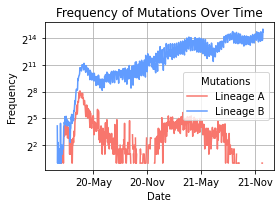

In [6]:
# Create the plot
fig, ax = plt.subplots(figsize=(4, 3))

color_map = {
    'Lineage A': '#f8766d',
    'Lineage B': '#619cff'
}

# Group data by 'Mutations' and plot each group
for label, grp in df1.groupby('Mutations'):
    ax.plot(grp['Var1'], grp['Freq'], label=label, color=color_map[label])

# Set the y-axis to log2 scale
ax.set_yscale('log', base=2)
# Set the date format for the x-axis
date_form = DateFormatter("%y-%b")
ax.xaxis.set_major_formatter(date_form)
# Set the locator for date ticks (every six months)
ax.xaxis.set_major_locator(MonthLocator(bymonthday=1, bymonth=[5, 11]))

# Formatting the plot
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Mutations Over Time')
ax.legend(title='Mutations')
ax.grid(True)


plt.tight_layout()  # Adjust layout to make room for the rotated date labels

# Show the plot
plt.show()


## EvoSIR model across-host

In [11]:
# Define the model function for simulation within PyMC3
def model_simulate(beta1, beta2, gamma, N, t_span, y0):
    # Redefine the model to work with constants
    def f(t, y):
        S, I1, I2, R = y
        dS_dt = -beta1 * S * I1 / N - beta2 * S * I2 / N
        dI1_dt = beta1 * S * I1 / N - gamma * I1
        dI2_dt = beta2 * S * I2 / N - gamma * I2
        dR_dt = gamma * I1 + gamma * I2
        return [dS_dt, dI1_dt, dI2_dt, dR_dt]

    # Wrap the differential equation solver as a Theano Op
    f_tt = theano.AsTensorType(f, itypes=[tt.dscalar, tt.dvector, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar])
    sol = solve_ivp(f_tt, t_span, y0, args=(beta1, beta2, gamma, N), t_eval=np.arange(t_span[0], t_span[1]))
    return sol.y[1], sol.y[2]


In [15]:
# Bayesian estimation using PyMC3
with pm.Model() as model:
    # Priors
    beta1 = pm.Normal('beta1', mu=0.4, sigma=0.1)
    beta2 = pm.Normal('beta2', mu=0.3, sigma=0.1)
    gamma = pm.Normal('gamma', mu=0.1, sigma=0.05)
    N = 10000  # Assuming a fixed population size
    
    # Initial conditions
    S0 = N - 10  # Initial susceptible
    I10 = 5      # Initial infected Lineage A
    I20 = 5      # Initial infected Lineage B
    R0 = 0       # Initial recovered
    y0 = [S0, I10, I20, R0]
    t_span = (0, 100)  # Time span for simulation
    
    # Define a Theano function that will compute beta1, beta2, gamma as numpy arrays
    compute_params = theano.function([], [beta1, beta2, gamma])

    # Obtain concrete values for parameters
    beta1_val, beta2_val, gamma_val = compute_params()

    # Simulate with these concrete values
    expected_I1, expected_I2 = model_simulate(beta1_val, beta2_val, gamma_val, N, (0, 100), [N - 10, 5, 5, 0])

    
    # Likelihood
    I1_observed = df[df['Mutations'] == 'Lineage A']['Freq'].values
    I2_observed = df[df['Mutations'] == 'Lineage B']['Freq'].values
    I1_likelihood = pm.Normal('I1_like', mu=expected_I1, sigma=10, observed=I1_observed)
    I2_likelihood = pm.Normal('I2_like', mu=expected_I2, sigma=10, observed=I2_observed)
    
    # Inference
    trace = pm.sample(100, return_inferencedata=False, progressbar=True)

MissingInputError: Undeclared input

In [24]:
df[df['Mutations'] == 'Lineage B']['Freq']

1015        1
1016        0
1017        1
1018        0
1019        0
        ...  
1718    19624
1719    13768
1720    15233
1721    33151
1722    26110
Name: Freq, Length: 708, dtype: int64

In [ ]:
# Bayesian estimation
with pm.Model() as model:
    # Priors for parameters based on hypothetical prior knowledge
    beta1 = pm.Normal('beta1', mu=0.4, sigma=0.1)
    beta2 = pm.Normal('beta2', mu=0.4, sigma=0.1)
    gamma = pm.Normal('gamma', mu=0.1, sigma=0.05)

    # Likelihood 
    I1_observed = df[df['Mutations'] == 'Lineage A']['Freq']
    I2_observed = df[df['Mutations'] == 'Lineage B']['Freq']
    I1_likelihood = pm.Normal('I1_likelihood', mu=beta1 * sol_across_host.y[0] * sol_across_host.y[1] / params_across_host['N'] - gamma1 * sol_across_host.y[1], sigma=10, observed=I1_observed)

    # Inference
    trace = pm.sample(500, return_inferencedata=False)

# Plot posterior estimates
az.plot_posterior(trace)
plt.show()

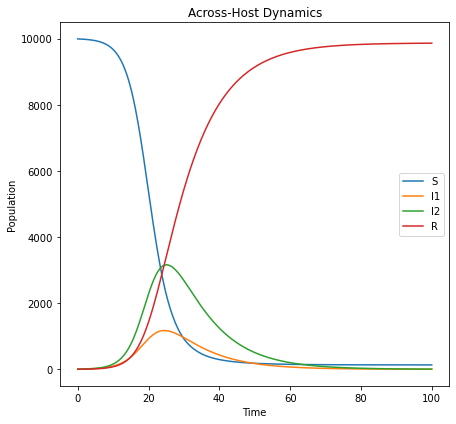

In [13]:
# Initial conditions and parameters for simulation
params_across_host = {'beta1': 0.4, 'beta2': 0.45, 'gamma': 0.1, 'N': 10000}
y0_across_host = [9990, 5, 5, 0]
t_span = (0, 100)
t_eval = np.linspace(0, 100, 400)

# Solve the differential equations
sol_across_host = solve_ivp(across_host_model, t_span, y0_across_host, \
                            args=(params_across_host['beta1'], params_across_host['beta2'], \
                                  params_across_host['gamma'], params_across_host['N']), \
                            t_eval=t_eval)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(122)
plt.plot(sol_across_host.t, sol_across_host.y[0], label='S')
plt.plot(sol_across_host.t, sol_across_host.y[1], label='I1')
plt.plot(sol_across_host.t, sol_across_host.y[2], label='I2')
plt.plot(sol_across_host.t, sol_across_host.y[3], label='R')
plt.title('Across-Host Dynamics')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:

# Bayesian estimation (simplified example using synthetic data and pymc3)
with pm.Model() as model:
    # Priors for parameters based on hypothetical prior knowledge
    beta1 = pm.Normal('beta1', mu=0.4, sigma=0.1)
    gamma1 = pm.Normal('gamma1', mu=0.1, sigma=0.05)

    # Likelihood (using synthetic data)
    I1_observed = sol_across_host.y[1] + np.random.normal(0, 10, size=len(sol_across_host.t))
    I1_likelihood = pm.Normal('I1_likelihood', mu=beta1 * sol_across_host.y[0] * sol_across_host.y[1] / params_across_host['N'] - gamma1 * sol_across_host.y[1], sigma=10, observed=I1_observed)

    # Inference
    trace = pm.sample(500, return_inferencedata=False)

# Plot posterior estimates
az.plot_posterior(trace)
plt.show()

In [2]:
import numpy as np
import aesara
import aesara.tensor as at
import pymc3 as pm
from scipy.integrate import solve_ivp

def ode_system(y, t, p):
    S, I1, I2, R = y
    beta1, beta2, gamma, N = p
    dS_dt = -beta1 * S * I1 / N - beta2 * S * I2 / N
    dI1_dt = beta1 * S * I1 / N - gamma * I1
    dI2_dt = beta2 * S * I2 / N - gamma * I2
    dR_dt = gamma * I1 + gamma * I2
    return [dS_dt, dI1_dt, dI2_dt, dR_dt]

# Define a function to compute the ODE solution
def solve_ode(y0, t_span, t_eval, beta1, beta2, gamma, N):
    sol = solve_ivp(ode_system, t_span, y0, t_eval=t_eval, args=([beta1, beta2, gamma, N],))
    return sol.y

# Convert this function into a Aesara compatible function
solve_ode_th = aesara.compile.builders.OpFromGraph(
    [at.dvector('initial_conditions'), at.dvector('t_span'), at.dvector('t_eval'), at.dscalar('beta1'), at.dscalar('beta2'), at.dscalar('gamma'), at.dscalar('N')],
    [at.as_tensor_variable(solve_ode(*inputs))],
    on_unused_input='ignore'
)



WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


NameError: name 'inputs' is not defined